In [1]:
using CSV, DataFrames, Statistics, Clustering, Plots, Random, Gurobi, JuMP, DataStructures, StatsBase

In [2]:
data_prev = CSV.read("data/pred_Maruipe.csv",DataFrame)
data_opti = CSV.read("data/opti_Maruipe.csv",DataFrame)

data_logistic = CSV.read("data/opti_Maria.csv",DataFrame)
pred_logistic = CSV.read("data/pred_lr.csv",DataFrame)[:, "0"];
pred_logistic_week = Matrix(CSV.read("data/pred_lr_week.csv",DataFrame))
pred_logistic_sms = Matrix(CSV.read("data/pred_lr_sms.csv",DataFrame))

pred_forest = CSV.read("data/y_new.csv", DataFrame)
pred_forest_sms = CSV.read("data/y_sms.csv", DataFrame);

In [3]:
#number booked appointments
na = nrow(data_prev)
#number new appointments
nb = nrow(data_opti)
ntot = na + nb
#number doctors
nd = 15
#penalty added nurse
pen_nurse = 1200
pen_noshow = 600
#previously_booked
s = data_prev.slot .+1 ;

In [4]:
p_logistic = ones(ntot,50)
for i = 1:na
    for j=1:50
        p_logistic[i,j] = 1 - pred_logistic[i]
    end
end
for i = na+1:ntot
    for j=1:50
        p_logistic[i,j] = 1 - pred_logistic[i-na]
    end
end

### Model 5 : maximize profit (penalize overbooking)

In [5]:
a = Matrix(data_opti[:,121:125]) .+ 1
p_oracle = ones(ntot,50)
for i = 1:na
    for j=1:50
        p_oracle[i,j] = 1 - data_prev.NoShow[i]
    end
end
for i = na+1:ntot
    for j=1:50
        p_oracle[i,j] = 1 - data_opti.NoShow[i-na]
    end
end;

In [6]:
p_forest = zeros(ntot,50)
for i = 1:na
    for j=1:50
        p_forest[i,j] = 1 - pred_forest[:,1][i]
    end
end
for i = na+1:ntot
    for j=1:length(a[1,:])
        p_forest[i,a[i-na,j]] = 1 - pred_forest[:,1][(i-na-1) + j]
    end
end

In [7]:
p_sms, p_nosms = pred_forest_sms[:,1], pred_forest_sms[:,2]

p_sms_m = ones(ntot,50)
for i = 1:na
    for j=1:50
        p_sms_m[i,j] = 1 - p_sms[i]
    end
end
for i = na+1:ntot
    for j=1:50
        p_sms_m[i,j] = 1 - p_sms[i-na]
    end
end

p_nosms_m = ones(ntot,50)
for i = 1:na
    for j=1:50
        p_nosms_m[i,j] = 1 - p_nosms[i]
    end
end
for i = na+1:ntot
    for j=1:50
        p_nosms_m[i,j] = 1 - p_nosms[i-na]
    end
end

In [8]:
nd = 7 #number doctors
ph = 600 #profit hour if patient shows up
ch = 90 #cost per hour booked
cd = 600
cs = 0.03

0.03

In [41]:
function optim_profit_double(p)
    model = Model(with_optimizer(Gurobi.Optimizer, TimeLimit=180))
    set_optimizer_attribute(model, "OutputFlag", 0)

    @variable(model, x[1:ntot, 1:50, 1:nd], Bin)
    @variable(model, t[1:50, 1:nd])

    @objective(model, Min, -ph*sum(x[i,j,k]*p[i,j] for i=1:ntot, j=1:50, k=1:nd) + cd*sum(t[j,k] for j=1:50, k=1:nd))
    #pb linear penalization : same to have 3 appointments in 1 hour than 2 slots double booked
    
    @constraint(model, [j=1:50, k=1:nd], t[j,k] >= 0)
    @constraint(model, [j=1:50, k=1:nd], t[j,k] >= sum(p[p1,j]*x[p1,j,k] + p[p2,j]*x[p2,j,k] -1  for p1=1:ntot, p2=p1+1:ntot))
    @constraint(model, [j=1:50, k=1:nd], sum(x[i,j,k] for i=1:ntot) <= 2)
    
    @constraint(model, [k=1:nd], sum(x[i,j,k] for i=1:ntot, j=1:50) <= 70)
    
    for i=1:na
        for j=1:50
            if s[i]==j
                @constraint(model, sum(x[i,j,:]) == 1)
            else
                @constraint(model, sum(x[i,j,:]) == 0)
            end
        end
    end

    for i=na+1:ntot
        for j=1:50
            if j in a[i-na,:]
            else
                @constraint(model, sum(x[i,j,:]) == 0)
            end
        end
    end

    @constraint(model, [i=1:ntot], sum(x[i,j,k] for j=1:50, k=1:nd) == 1)

    optimize!(model)
    return objective_value(model), JuMP.value.(x), JuMP.value.(t)
end

optim_profit_double (generic function with 1 method)

In [ ]:
function optim_profit_double(p)
    model = Model(with_optimizer(Gurobi.Optimizer, TimeLimit=180))
    set_optimizer_attribute(model, "OutputFlag", 0)

    @variable(model, x[1:ntot, 1:50, 1:nd], Bin)
    @variable(model, t[1:50, 1:nd])

    @objective(model, Min, -ph*sum(x[i,j,k]*p[i,j] for i=1:ntot, j=1:50, k=1:nd) + (cd+ph)*sum(t[j,k] for j=1:50, k=1:nd))
    #pb linear penalization : same to have 3 appointments in 1 hour than 2 slots double booked
    
    @constraint(model, [j=1:50, k=1:nd], t[j,k] >= 0)
    @constraint(model, [j=1:50, k=1:nd], t[j,k] >= sum(p[p1,j]*p[p2,j]*(x[p1,j,k] + x[p2,j,k] -1)  for p1=1:ntot, p2=p1+1:ntot))
    @constraint(model, [j=1:50, k=1:nd], sum(x[i,j,k] for i=1:ntot) <= 2)
    
    @constraint(model, [k=1:nd], sum(x[i,j,k] for i=1:ntot, j=1:50) <= 70)
    
    for i=1:na
        for j=1:50
            if s[i]==j
                @constraint(model, sum(x[i,j,:]) == 1)
            else
                @constraint(model, sum(x[i,j,:]) == 0)
            end
        end
    end

    for i=na+1:ntot
        for j=1:50
            if j in a[i-na,:]
            else
                @constraint(model, sum(x[i,j,:]) == 0)
            end
        end
    end

    @constraint(model, [i=1:ntot], sum(x[i,j,k] for j=1:50, k=1:nd) == 1)

    optimize!(model)
    return objective_value(model), JuMP.value.(x), JuMP.value.(t)
end

In [42]:
_, x, t = optim_profit_double(p_oracle)

Academic license - for non-commercial use only - expires 2022-08-18


(-180000.0, [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0])

In [43]:
_, xl, tl = optim_profit_double(p_forest)

Academic license - for non-commercial use only - expires 2022-08-18


(-166325.87534405245, [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0])

In [44]:
-ph*sum(xl[i,j,k]*p_oracle[i,j] for i=1:ntot, j=1:50, k=1:nd) + cd*sum(max(sum(p_oracle[i,j]*xl[i,j,k] for i=1:ntot)-1, 0) for j=1:50, k=1:nd)

-123000.0

In [45]:
p_no_idea = ones(ntot, 50);

In [46]:
_, xn, tn = optim_profit_double(p_no_idea);

Academic license - for non-commercial use only - expires 2022-08-18


In [47]:
-ph*sum(xn[i,j,k]*p_oracle[i,j] for i=1:ntot, j=1:50, k=1:nd) + cd*sum(max(sum(p_oracle[i,j]*xn[i,j,k] for i=1:ntot)-1, 0) for j=1:50, k=1:nd)

-133200.0

### Model 5 : prescription

In [21]:
p_forest[1]*1000

727.5224558267213

In [35]:
function optim_profit_double(p)
    model = Model(with_optimizer(Gurobi.Optimizer, TimeLimit=180))
    set_optimizer_attribute(model, "OutputFlag", 0)

    @variable(model, x[1:ntot, 1:50, 1:nd], Bin)
    #@variable(model, t[1:50, 1:nd])
    @variable(model, t[1:ntot, 1:ntot, 1:50, 1:nd])

    #@objective(model, Min, -ph*sum(x[i,j,k]*p[i,j] for i=1:ntot, j=1:50, k=1:nd) + cd*sum(t[j,k] for j=1:50, k=1:nd))
    @objective(model, Min, -ph*sum(x[i,j,k]*p[i,j] for i=1:ntot, j=1:50, k=1:nd) + cd*sum((1/1000)^2*sum(sum(t[p1,p2,j,k] for i1=1:Int(1000*p[p1,j]), i2=1:Int(1000*p[p2,j]))
            for p1=1:ntot, p2=p1+1:ntot) for j=1:50, k=1:nd))
    
    #@constraint(model, [j=1:50, k=1:nd], t[j,k] >= 0)
    #@constraint(model, [j=1:50, k=1:nd], t[j,k] >= (1/1000)^2*sum(sum(max(x[p1,j,k] + x[p2,j,k] -1,0) for i1=1:Int(1000*p[p1,j]), i2=1:Int(1000*p[p2,j]))
            #+ sum(max(x[p1,j,k] -1,0) for i1=1:Int(1000*p[p1,j]), i2=1:Int(1000*p[p2,j]))
            #for p1=1:ntot, p2=p1+1:ntot))
    @constraint(model, [p1=1:ntot, p2=1:ntot, j=1:50, k=1:nd], t[p1,p2,j,k] <= 0)
    @constraint(model, [p1=1:ntot, p2=1:ntot, j=1:50, k=1:nd], t[p1,p2,j,k] >= x[p1,j,k] + x[p2,j,k] -1)
    @constraint(model, [j=1:50, k=1:nd], sum(x[i,j,k] for i=1:ntot) <= 2)
    
    @constraint(model, [k=1:nd], sum(x[i,j,k] for i=1:ntot, j=1:50) <= 70)
    
    for i=1:na
        for j=1:50
            if s[i]==j
                @constraint(model, sum(x[i,j,:]) == 1)
            else
                @constraint(model, sum(x[i,j,:]) == 0)
            end
        end
    end

    for i=na+1:ntot
        for j=1:50
            if j in a[i-na,:]
            else
                @constraint(model, sum(x[i,j,:]) == 0)
            end
        end
    end

    @constraint(model, [i=1:ntot], sum(x[i,j,k] for j=1:50, k=1:nd) == 1)

    optimize!(model)
    return objective_value(model), JuMP.value.(x), JuMP.value.(t)
end

optim_profit_double (generic function with 1 method)

### Model 6 : max profit under paying assumption

In [29]:
function optim_profit_hole2(p)
    model = Model(with_optimizer(Gurobi.Optimizer, TimeLimit=180))
    set_optimizer_attribute(model, "OutputFlag", 0)

    @variable(model, x[1:ntot, 1:50, 1:nd], Bin)
    @variable(model, u[1:nd, 1:5, 1:10], Bin)
    @variable(model, v[1:nd, 1:5, 1:10], Bin)
    @variable(model, w[1:nd, 1:5, 1:10], Bin)

    @objective(model, Min, -ph*sum(x[i,j,k]*p[i,j] for i=1:ntot, j=1:50, k=1:nd) + ch*sum(w))
    
    for k=1:nd
        for l=1:5
            for i=1:10
                for j=i+1:10
                    @constraint(model, u[k,l,i] <= u[k,l,j])
                    @constraint(model, v[k,l,i] >= v[k,l,j])
                end
            end
        end
    end
    @constraint(model, [k=1:nd, l=1:5, j=1:10], u[k,l,j] >= sum(x[i,10*(l-1)+j,k] for i=1:ntot)/ntot)
    @constraint(model, [k=1:nd, l=1:5, j=1:10], v[k,l,j] >= sum(x[i,10*(l-1)+j,k] for i=1:ntot)/ntot)
    
    @constraint(model, [k=1:nd, l=1:5, j=1:10], w[k,l,j] >= u[k,l,j] + v[k,l,j] - 1)
    @constraint(model, [k=1:nd, l=1:5, j=1:10], w[k,l,j] <= (u[k,l,j] + v[k,l,j])/2)
    
    @constraint(model, [j=1:50, k=1:nd], sum(x[i,j,k] for i=1:ntot) <= 2)
    @constraint(model, [k=1:nd], sum(x[i,j,k] for i=1:ntot, j=1:50) <= 70)
    
    for i=1:na
        for j=1:50
            if s[i]==j
                @constraint(model, sum(x[i,j,:]) == 1)
            else
                @constraint(model, sum(x[i,j,:]) == 0)
            end
        end
    end

    for i=na+1:ntot
        for j=1:50
            if j in a[i-na,:]
            else
                @constraint(model, sum(x[i,j,:]) == 0)
            end
        end
    end

    @constraint(model, [i=1:ntot], sum(x[i,j,k] for j=1:50, k=1:nd) == 1)

    optimize!(model)
    return objective_value(model), JuMP.value.(x), JuMP.value.(w)
end

optim_profit_hole2 (generic function with 1 method)

In [116]:
_, x, w = optim_profit_hole2(p_oracle);

Academic license - for non-commercial use only - expires 2022-08-18


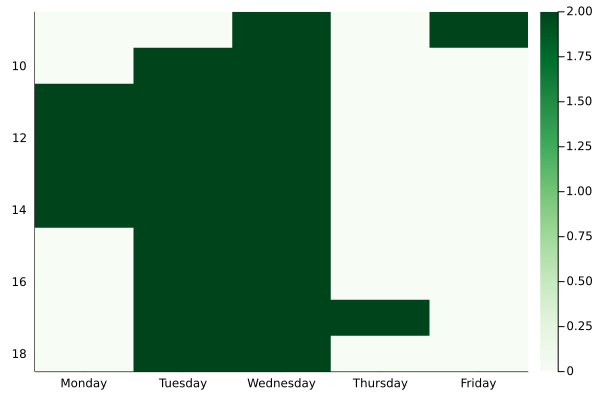

In [117]:
x_h = reshape(sum(x[i,:, 3] for i=1:ntot), (10,5))
heatmap(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"], [9:18], x_h, yflip = true, c=:Greens_9)

In [122]:
olog, xlog, wlog = optim_profit_hole2(p_forest);

Academic license - for non-commercial use only - expires 2022-08-18


In [157]:
-ph*sum(xlog[i,j,k]*p_oracle[i,j] for i=1:ntot, j=1:50, k=1:nd) + ch*sum(wlog)

-130140.0

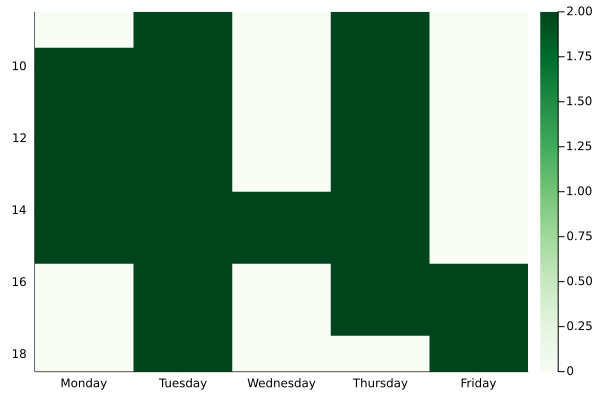

In [159]:
xlog_h = reshape(sum(xlog[i,:, 2] for i=1:ntot), (10,5))
heatmap(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"], [9:18], xlog_h, yflip = true, c=:Greens_9)

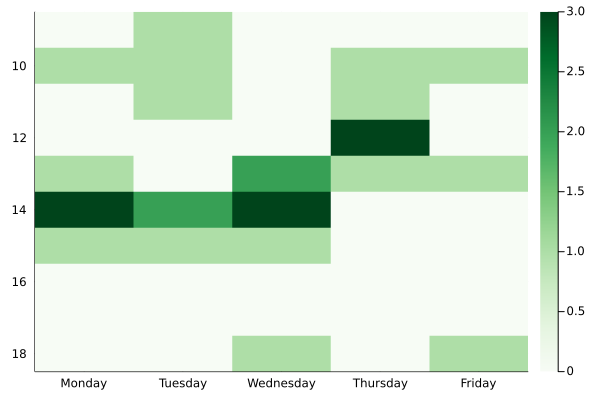

In [121]:
xlog_h = reshape([sum(xlog[i,j, 3]*p_oracle[i,j] for i=1:ntot) for j=1:50], (10,5))
heatmap(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"], [9:18], xlog_h, yflip = true, c=:Greens_9)

### Model 7 : include sms

In [9]:
cs = 0.03 #cost sms

0.03

In [105]:
function optim_profit_sms(p_sms, p_nosms)
    model = Model(with_optimizer(Gurobi.Optimizer, TimeLimit=180))
    set_optimizer_attribute(model, "OutputFlag", 0)

    @variable(model, x[1:ntot, 1:50, 1:nd], Bin)
    @variable(model, r[1:ntot, 1:50], Bin)
    @variable(model, z[1:ntot, 1:50], Bin)

    @objective(model, Min, -ph*sum(z[i,j]*p_sms[i,j] + p_nosms[i,j]*(sum(x[i,j,k] for k=1:nd)- z[i,j]) for i=1:ntot, j=1:50) + cs*sum(z))

    @constraint(model, [i=1:ntot, j=1:50], z[i,j] <= (sum(x[i,j,k] for k=1:nd) + r[i,j])/2)
    @constraint(model, [i=1:ntot, j=1:50], z[i,j] >= sum(x[i,j,k] for k=1:nd) + r[i,j] - 1)
    
    for i=1:na
        for j=1:50
            if s[i]==j
                @constraint(model, sum(x[i,j,:]) == 1)
            else
                @constraint(model, sum(x[i,j,:]) == 0)
            end
        end
    end

    for i=na+1:ntot
        for j=1:50
            if j in a[i-na,:]
            else
                @constraint(model, sum(x[i,j,:]) == 0)
            end
        end
    end

    @constraint(model, [i=1:ntot], sum(x[i,j,k] for j=1:50, k=1:nd) == 1)

    optimize!(model)
    return objective_value(model), JuMP.value.(x), JuMP.value.(z)
end

optim_profit_sms (generic function with 1 method)

In [106]:
_, xlog, z_log = optim_profit_sms(p_sms_m, p_nosms_m)

Academic license - for non-commercial use only - expires 2022-08-18


(-162767.32031231065, [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0])

In [107]:
sum(z_log)

323.0

In [108]:
smssent = findall(x -> x==1, z_log)
#counts([smssent[i][2] for i = 1:length(smssent)], 1:50)

323-element Vector{CartesianIndex{2}}:
 CartesianIndex(101, 1)
 CartesianIndex(102, 1)
 CartesianIndex(235, 1)
 CartesianIndex(257, 1)
 CartesianIndex(271, 1)
 CartesianIndex(29, 2)
 CartesianIndex(38, 2)
 CartesianIndex(83, 2)
 CartesianIndex(100, 2)
 CartesianIndex(229, 2)
 CartesianIndex(248, 2)
 CartesianIndex(263, 2)
 CartesianIndex(269, 2)
 ⋮
 CartesianIndex(126, 49)
 CartesianIndex(197, 49)
 CartesianIndex(219, 49)
 CartesianIndex(292, 49)
 CartesianIndex(297, 49)
 CartesianIndex(304, 49)
 CartesianIndex(310, 49)
 CartesianIndex(320, 49)
 CartesianIndex(160, 50)
 CartesianIndex(309, 50)
 CartesianIndex(323, 50)
 CartesianIndex(339, 50)

In [109]:
l_time = zeros(0)

for i=1:length(smssent)
    idx = smssent[i][1]
    if idx <=228
        append!(l_time, data_prev.AwaitingTime[idx,:])
    else
        append!(l_time, data_opti.AwaitingTime[idx-228,:])
    end
end

In [113]:
scatter(1:179, counts(Int.(l_time), 1:179) ./ counts(vcat(data_prev.AwaitingTime, data_opti.AwaitingTime), 1:179), dpi=1000, title="Relation between SMS sent and awaiting days", ylabel="% of patients receiving an SMS", xlabel="# awaiting days")
savefig("output.png")

In [17]:
maximum(l_time)

179.0

In [18]:
minimum(l_time)

0.0

In [19]:
counts(Int.(l_time), 1:179)

179-element Vector{Int64}:
 16
 17
  9
  2
  2
 14
  9
  3
  2
  2
  3
  2
  5
  ⋮
  0
  0
  0
  0
  0
  0
  0
  0
  6
  0
  0
  4

In [20]:
mean(l_time)

21.461300309597522

In [21]:
(sum(data_prev.AwaitingTime) + sum(data_opti.AwaitingTime))/ntot

20.096354166666668

In [22]:
data_prev.AwaitingTime[10]

40

In [23]:
p_sms[10] - p_nosms[10]

-0.04680409544598002

In [24]:
p_sms

384-element Vector{Float64}:
 0.2724775441732787
 0.3085210178706919
 0.2880565191979734
 0.2391823228298011
 0.20564467963029395
 0.35304384489702656
 0.3378109549038808
 0.282165231795308
 0.3162413600498995
 0.35328007882383866
 0.212718045845908
 0.19917075298334166
 0.17365893749063738
 ⋮
 0.14375370461152742
 0.10193452868986867
 0.13986091989256696
 0.18992997796059272
 0.2863345106388426
 0.19855073752762367
 0.28285635904803913
 0.14592187104612925
 0.21705347096691913
 0.2063008788180929
 0.29573407061642887
 0.23712439709519587

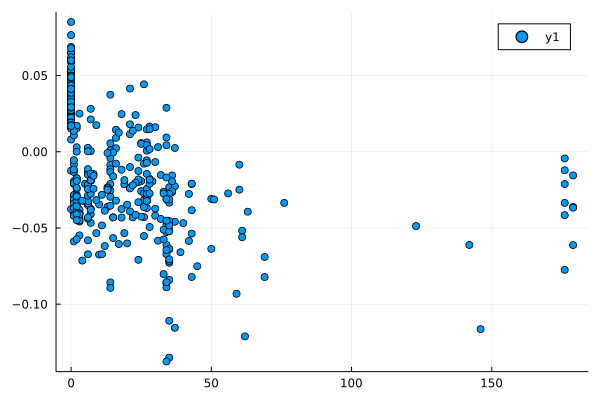

In [27]:
scatter(vcat(data_prev.AwaitingTime, data_opti.AwaitingTime), p_sms - p_nosms)

In [29]:
counts(vcat(data_prev.AwaitingTime, data_opti.AwaitingTime), 1:179)

179-element Vector{Int64}:
 20
 24
  9
  2
  2
 16
 12
  3
  3
  2
  3
  2
  5
  ⋮
  0
  0
  0
  0
  0
  0
  0
  0
  6
  0
  0
  4

### Model 8 : all combined (day)

In [42]:
function optim_profit_combined(p_sms, p_nosms)
    model = Model(with_optimizer(Gurobi.Optimizer, TimeLimit=120))
    set_optimizer_attribute(model, "OutputFlag", 0)

    @variable(model, x[1:ntot, 1:50, 1:nd], Bin)
    @variable(model, t[1:50, 1:nd])
    @variable(model, u[1:nd, 1:5, 1:10], Bin)
    @variable(model, v[1:nd, 1:5, 1:10], Bin)
    @variable(model, w[1:nd, 1:5, 1:10], Bin)
    @variable(model, r[1:ntot, 1:50], Bin)
    @variable(model, z[1:ntot, 1:50, 1:nd], Bin)

    @objective(model, Min, -ph*sum(sum(z[i,j,k] for k=1:nd)*p_sms[i,j] + p_nosms[i,j]*sum(x[i,j,k] - z[i,j,k] for k=1:nd) for i=1:ntot, j=1:50) + (cd+ph)*sum(t[j,k] for j=1:50, k=1:nd) + ch*sum(w) + cs*sum(z))
    
    @constraint(model, [j=1:50, k=1:nd], sum(x[i,j,k] for i=1:ntot) <= 2)
    @constraint(model, [k=1:nd], sum(x[i,j,k] for i=1:ntot, j=1:50) <= 70)
    
    #Linearization model double booking
    @constraint(model, [j=1:50, k=1:nd], t[j,k] >= 0)
    @constraint(model, [j=1:50, k=1:nd], t[j,k] >= sum(p_sms[p1,j]*(z[p1,j,k]) + p_nosms[p1,j]*(x[p1,j,k] - z[p1,j,k]) + p_sms[p2,j]*(z[p2,j,k]) + p_nosms[p2,j]*(x[p2,j,k] - z[p2,j,k]) 
            for p1=1:ntot, p2=p1+1:ntot) - 1)
    #@constraint(model, [j=1:50, k=1:nd], t[j,k] >= sum(z[i,j,k]*p_sms[i,j] + p_nosms[i,j]*(x[i,j,k] - z[i,j,k]) for i=1:ntot) -1)
    
    #Linearization model hole
    for k=1:nd
        for l=1:5
            for i=1:10
                for j=i+1:10
                    @constraint(model, u[k,l,i] <= u[k,l,j])
                    @constraint(model, v[k,l,i] >= v[k,l,j])
                end
            end
        end
    end
    @constraint(model, [k=1:nd, l=1:5, j=1:10], u[k,l,j] >= sum(x[i,10*(l-1)+j,k] for i=1:ntot)/ntot)
    @constraint(model, [k=1:nd, l=1:5, j=1:10], v[k,l,j] >= sum(x[i,10*(l-1)+j,k] for i=1:ntot)/ntot)
    
    @constraint(model, [k=1:nd, l=1:5, j=1:10], w[k,l,j] >= u[k,l,j] + v[k,l,j] - 1)
    @constraint(model, [k=1:nd, l=1:5, j=1:10], w[k,l,j] <= (u[k,l,j] + v[k,l,j])/2)
    
    #Linearization model sms
    @constraint(model, [i=1:ntot, j=1:50, k=1:nd], z[i,j,k] <= (x[i,j,k] + r[i,j])/2)
    @constraint(model, [i=1:ntot, j=1:50, k=1:nd], z[i,j,k] >= x[i,j,k] + r[i,j] - 1)
    
    #Other constraints    
    for i=1:na
        for j=1:50
            if s[i]==j
                @constraint(model, sum(x[i,j,:]) == 1)
            else
                @constraint(model, sum(x[i,j,:]) == 0)
            end
        end
    end

    for i=na+1:ntot
        for j=1:50
            if j in a[i-na,:]
            else
                @constraint(model, sum(x[i,j,:]) == 0)
            end
        end
    end

    @constraint(model, [i=1:ntot], sum(x[i,j,k] for j=1:50, k=1:nd) == 1)

    optimize!(model)
    return objective_value(model), JuMP.value.(x), JuMP.value.(t), JuMP.value.(w), JuMP.value.(z)
end

optim_profit_combined (generic function with 1 method)

In [ ]:
o, x, t, w, z = optim_profit_combined(p_sms_m, p_nosms_m)

In [ ]:
-ph*sum(sum(z[i,j,k] for k=1:nd)*p_oracle[i,j] + p_oracle[i,j]*sum(x[i,j,k] - z[i,j,k] for k=1:nd) for i=1:ntot, j=1:50) + cd*sum(max(sum(z[i,j,k]*p_oracle[i,j] + p_oracle[i,j]*(x[i,j,k] - z[i,j,k]) for i=1:ntot) -1, 0) for j=1:50, k=1:nd) + ch*sum(w) + cs*sum(z)

In [ ]:
p_sms_05 = ones(ntot,50)#*0.5#
p_nosms_05 = ones(ntot,50);#*0.5;

In [ ]:
mean((p_sms_m - p_nosms_m)/p_nosms_m)

In [ ]:
or, xr, tr, wr, zr = optim_profit_combined(p_sms_05, p_sms_05)

In [ ]:
-ph*sum(sum(zr[i,j,k] for k=1:nd)*p_oracle[i,j] + p_oracle[i,j]*sum(xr[i,j,k] - zr[i,j,k] for k=1:nd) for i=1:ntot, j=1:50) + cd*sum(max(sum(zr[i,j,k]*p_oracle[i,j] + p_oracle[i,j]*(xr[i,j,k] - zr[i,j,k]) for i=1:ntot) -1, 0) for j=1:50, k=1:nd) + ch*sum(wr) + cs*sum(zr)

In [ ]:
ntot

In [57]:
function optim_profit_combined(p_sms, p_nosms)
    model = Model(with_optimizer(Gurobi.Optimizer, TimeLimit=120))
    set_optimizer_attribute(model, "OutputFlag", 0)

    @variable(model, x[1:ntot, 1:50, 1:nd], Bin)
    @variable(model, t[1:50, 1:nd, 1:ntot, 1:ntot])
    @variable(model, u[1:nd, 1:5, 1:10], Bin)
    @variable(model, v[1:nd, 1:5, 1:10], Bin)
    @variable(model, w[1:nd, 1:5, 1:10], Bin)
    @variable(model, r[1:ntot, 1:50], Bin)
    @variable(model, z[1:ntot, 1:50, 1:nd], Bin)

    @objective(model, Min, -ph*sum(sum(z[i,j,k] for k=1:nd)*p_sms[i,j] + p_nosms[i,j]*sum(x[i,j,k] - z[i,j,k] for k=1:nd) for i=1:ntot, j=1:50)
        + cd*sum(t[j,k, p1, p2] for j=1:50, k=1:nd, p1=1:ntot, p2=p1+1:ntot) + ch*sum(w) + cs*sum(z))
    
    @constraint(model, [j=1:50, k=1:nd], sum(x[i,j,k] for i=1:ntot) <= 2)
    @constraint(model, [k=1:nd], sum(x[i,j,k] for i=1:ntot, j=1:50) <= 70)
    
    #Linearization model double booking
    for p1=1:ntot
        for p2=p1+1:ntot
            @constraint(model, [j=1:50, k=1:nd], t[j, k, p1, p2] >= 0)
            @constraint(model, [j=1:50, k=1:nd], t[j, k, p1, p2] >= p_nosms[p1,j]*p_nosms[p2,j]*(x[p1,j,k] - z[p1,j,k] + x[p2,j,k] - z[p2,j,k] - 1)
                    + p_sms[p1,j]*p_nosms[p2,j]*(z[p1,j,k] + x[p2,j,k] - z[p2,j,k] - 1) 
                    + p_sms[p2,j]*p_nosms[p1,j]*(z[p2,j,k] + x[p1,j,k] - z[p1,j,k] - 1)) 
        end
    end

    
    #Linearization model hole
    for k=1:nd
        for l=1:5
            for i=1:10
                for j=i+1:10
                    @constraint(model, u[k,l,i] <= u[k,l,j])
                    @constraint(model, v[k,l,i] >= v[k,l,j])
                end
            end
        end
    end
    @constraint(model, [k=1:nd, l=1:5, j=1:10], u[k,l,j] >= sum(x[i,10*(l-1)+j,k] for i=1:ntot)/ntot)
    @constraint(model, [k=1:nd, l=1:5, j=1:10], v[k,l,j] >= sum(x[i,10*(l-1)+j,k] for i=1:ntot)/ntot)
    
    @constraint(model, [k=1:nd, l=1:5, j=1:10], w[k,l,j] >= u[k,l,j] + v[k,l,j] - 1)
    @constraint(model, [k=1:nd, l=1:5, j=1:10], w[k,l,j] <= (u[k,l,j] + v[k,l,j])/2)
    
    #Linearization model sms
    @constraint(model, [i=1:ntot, j=1:50, k=1:nd], z[i,j,k] <= (x[i,j,k] + r[i,j])/2)
    @constraint(model, [i=1:ntot, j=1:50, k=1:nd], z[i,j,k] >= x[i,j,k] + r[i,j] - 1)
    
    #Other constraints    
    for i=1:na
        for j=1:50
            if s[i]==j
                @constraint(model, sum(x[i,j,:]) == 1)
            else
                @constraint(model, sum(x[i,j,:]) == 0)
            end
        end
    end

    for i=na+1:ntot
        for j=1:50
            if j in a[i-na,:]
            else
                @constraint(model, sum(x[i,j,:]) == 0)
            end
        end
    end

    @constraint(model, [i=1:ntot], sum(x[i,j,k] for j=1:50, k=1:nd) == 1)

    optimize!(model)
    return objective_value(model), JuMP.value.(x), JuMP.value.(t), JuMP.value.(w), JuMP.value.(z)
end

optim_profit_combined (generic function with 1 method)